In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

### Решить задачу многоклассовой классификации с помощью многослойной нейронной сети, состоящей из полносвязных слоев.

In [2]:
# загружаем данные и разбиваем их на составляющие
train = pd.read_csv("./train.csv")
y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

In [3]:

X_train = normalize(X_train.astype('float32'), axis=1)

# Из файла информацию о изображения с цифрами мы получили в виде одномерных векторов из 784 значений
# Переформируем все данные в трехмерные матрицы 28x28x1.
# Keras требует дополнительное измерение в конце, для каналов. 
# Если бы это были RGB-изображения, то было бы 3 канала, но поскольку у нас "черно-белое" изображение, мы указываем 1 серый канал.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

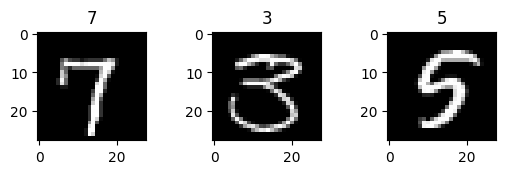

In [4]:
# убедимся, что все ок, выведем сами тестовые изображения и соответствующие им цифры 
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

Стандартизация особенностей - это важный этап предварительной обработки. Он используется для центрирования данных вокруг нулевого среднего и единичной дисперсии.

In [5]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)
def standardize(x): 
    return (x-mean_px)/std_px

Метки в данном случае представлены целыми числами от 0 до 9. 
Нам нужно применить one-hot encoding, чтобы преобразовать эти one-hot числовой массив (например: 2 -> [0,0,1,0,0,0,0,0,0,0,0]).

In [6]:
print(f"{y_train[0]} преобрауется в ")
y_train = to_categorical(y_train, num_classes = 10)
# Пример:
print(y_train[0])

1 преобрауется в 
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [8]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [9]:
model = Sequential()
model.add(Lambda(standardize,input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(128, activation='relu')),
model.add(Dense(128, activation='relu')),
model.add(Dense(10, activation='softmax'))

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Определим callback для сохранения весов на каждой этапе обучения
# Это понадобится позже для определения параметров, при которых точность максимальна
checkpoint_callback = ModelCheckpoint(
    filepath='weights.{epoch:02d}.h5',
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)

history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    epochs=29, 
                    verbose=1,
                    validation_data=(X_test, y_test), callbacks=[checkpoint_callback])

loss, accuracy = model.evaluate(X_test, y_test)

print(f"Final loss: {loss}")
print(f"Final accuracy: {accuracy}")


Epoch 1/29


2100/2100 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.8464
Epoch 1: saving model to weights.01.h5
2100/2100 [==============================] - 14s 6ms/step - loss: 0.4819 - accuracy: 0.8464 - val_loss: 0.1907 - val_accuracy: 0.9414
Epoch 2/29
2100/2100 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.9203
Epoch 2: saving model to weights.02.h5
2100/2100 [==============================] - 14s 6ms/step - loss: 0.2530 - accuracy: 0.9203 - val_loss: 0.1673 - val_accuracy: 0.9469
Epoch 3/29
2098/2100 [============================>.] - ETA: 0s - loss: 0.2141 - accuracy: 0.9337
Epoch 3: saving model to weights.03.h5
2100/2100 [==============================] - 14s 6ms/step - loss: 0.2140 - accuracy: 0.9337 - val_loss: 0.1457 - val_accuracy: 0.9530
Epoch 4/29
2100/2100 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.9411
Epoch 4: saving model to weights.04.h5
2100/2100 [==============================] - 13s

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Посмотрим, как происходило изменение точности на каждой из эпох

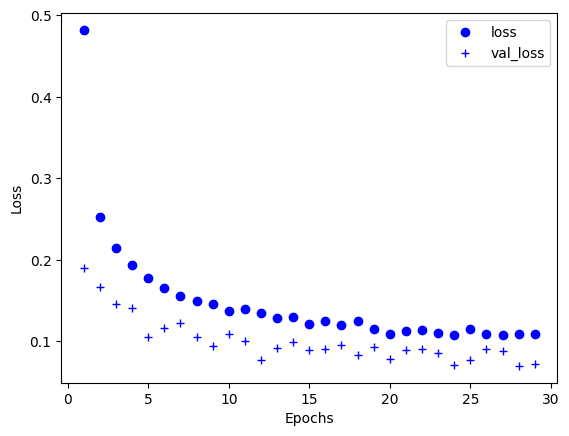

In [13]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo')
plt.plot(epochs, val_loss_values, 'b+')
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

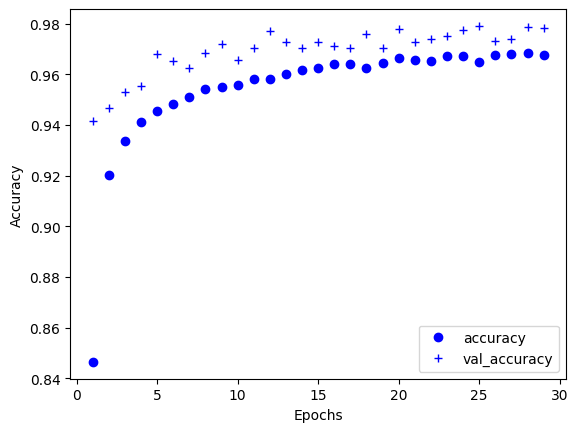

In [14]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

### Вычислить градиент целевой функции по обучаемым параметрам нейронной сети, сравнить полученные значения со значениями, вычисленными с помощью библиотечных функций

In [15]:
# Найдем градиенты через tf.GradientTape
with tf.GradientTape() as tape:
    y_pred = model(X_test)
    loss_value = tf.keras.losses.categorical_crossentropy(y_test, y_pred)

# Рассчитать градиенты потерь по отношению к обучаемым переменным модели
gradients = tape.gradient(loss_value, model.trainable_variables)

# Выведем сами градиенты и переменные, к которым они относятся
for var, grad in zip(model.trainable_variables, gradients):
    print(f"Variable: {var.name}, Gradient shape: {grad.shape}")
    print(grad.numpy())

Variable: dense/kernel:0, Gradient shape: (784, 128)
[[ 1.1608798e-02  6.9909668e-01 -8.1845246e-02 ... -4.4582456e-02
  -4.8950019e-01  6.7492813e-04]
 [ 1.1608798e-02  6.9909668e-01 -8.1845246e-02 ... -4.4582456e-02
  -4.8950019e-01  6.7492813e-04]
 [ 1.1608798e-02  6.9909668e-01 -8.1845246e-02 ... -4.4582456e-02
  -4.8950019e-01  6.7492813e-04]
 ...
 [ 1.1608798e-02  6.9909668e-01 -8.1845246e-02 ... -4.4582456e-02
  -4.8950019e-01  6.7492813e-04]
 [ 1.1608798e-02  6.9909668e-01 -8.1845246e-02 ... -4.4582456e-02
  -4.8950019e-01  6.7492813e-04]
 [ 1.1608798e-02  6.9909668e-01 -8.1845246e-02 ... -4.4582456e-02
  -4.8950019e-01  6.7492813e-04]]
Variable: dense/bias:0, Gradient shape: (128,)
[-2.76908502e-02 -1.66761243e+00  1.95232332e-01  4.72614467e-01
 -7.95422047e-02  2.63594687e-01 -5.44211149e+00 -5.59582338e-02
 -7.05127001e-01 -1.91984594e+00  5.45436144e-03  8.14600229e-01
  1.41080737e+00 -1.28690422e+00 -5.29121518e-01 -2.03978330e-01
  1.81721985e+00  7.98329949e-01 -7.9012

### Определить параметры нейронной сети, при которых точность классификации максимальна

Чтобы определить параметры нейронной сети, при которых точность классификации максимальна, мы
- должны проанализировать объект history, возвращаемый методом fit(), который содержит историю обучения, включая значения точности для каждой эпохи;
- найти эпоху с лучшей точностью проверки;
- по мере обучения модели мы сохраняем веса, полученные на каждой эпохе, в отдельный файл. Загрузим веса из файла соответсвующего эпохе с лучшей точностью;
- используем model.get_weights() для получения параметров (весов и смещений) модели в лучшую эпоху. Мы перебираем параметры и выводим их формы, чтобы проверить размеры параметров каждого слоя.

In [16]:
# Найдем эпоху с наивысшей точностью валидации
best_epoch = np.argmax(history.history['val_accuracy'])
best_accuracy = history.history['val_accuracy'][best_epoch]

# Получим веса модели для этой эпохи из файла, сохраненного ранее на этапе обучения
model.load_weights(f'weights.{best_epoch+1:02d}.h5')

# Получим параметры модели для лучшей эпохи
best_parameters = model.get_weights()

print(f"Best accuracy: {best_accuracy}")
print("Best params:")
for layer_param in best_parameters:
    print(layer_param)

Best accuracy: 0.9791666865348816
Best params:
[[-0.04629204  0.06990304  0.0258188  ... -0.0710553   0.18708406
   0.15787755]
 [ 0.06423483  0.04526265  0.04913613 ... -0.10262723  0.09807988
   0.01804112]
 [-0.04484887  0.00375663  0.12461584 ... -0.03612404  0.22367525
   0.02426236]
 ...
 [-0.01531738  0.08001369  0.13642788 ... -0.08366265  0.09461308
   0.11169851]
 [ 0.00280763  0.04329168  0.09190278 ... -0.10850544  0.06513637
   0.1288529 ]
 [ 0.02505323  0.01513023  0.01823278 ... -0.13223131  0.15637478
   0.10989331]]
[-0.00338947 -0.03522573 -0.07446598 -0.06563316 -0.17879623  0.11249764
 -0.13821243 -0.09273798 -0.09154113  0.16389397 -0.06216674 -0.1315785
 -0.14293465 -0.01786655 -0.10030112 -0.12182294 -0.04514779 -0.06400953
  0.01290062 -0.04772647 -0.03516588 -0.09726825 -0.19053268 -0.13331857
  0.03641406 -0.15574157 -0.12375885 -0.11347263 -0.06743915 -0.14561841
 -0.05805733 -0.02485945 -0.12787129  0.05488549 -0.12868126 -0.06395329
 -0.09099336 -0.21838562

In [17]:
print("Описание модели:")
model.summary()

Описание модели:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 28, 28, 1)         0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118282 (462.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________